In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
img_height = 64
img_width = 64
batch_size = 64
epsilon = 1.0

In [3]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, img

In [4]:
file_dir = '../../Datasets/CelebA/img_align_celeba/000001.jpg'
img, label = process_path(file_dir)
print(img.shape)

(64, 64, 3)


2023-04-16 14:35:58.072230: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 14:35:58.663679: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11414 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:83:00.0, compute capability: 6.1


In [5]:
import numpy as np

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def fairRR(arr, eps, num_int, num_bit, mode = 'dp'):
    r = arr.shape[1]
    num_pt = arr.shape[0]
    
    def float_to_binary(x, m=num_int, n=num_bit - num_int - 1):
        x_abs = np.abs(x)
        x_scaled = round(x_abs * 2 ** n)
        res = '{:0{}b}'.format(x_scaled, m + n)
        if x >= 0:
            res = '0' + res
        else:
            res = '1' + res
        return res

    # binary to float
    def binary_to_float(bstr, m=num_int, n=num_bit - num_int - 1):
        sign = bstr[0]
        bs = bstr[1:]
        res = int(bs, 2) / 2 ** n
        if int(sign) == 1:
            res = -1 * res
        return res

    def string_to_int(a):
        bit_str = "".join(x for x in a)
        return np.array(list(bit_str)).astype(int)

    def join_string(a, num_bit=num_bit, num_feat=r):
        res = np.empty(num_feat, dtype="S10")
        # res = []
        for i in range(num_feat):
            # res.append("".join(str(x) for x in a[i*l:(i+1)*l]))
            res[i] = "".join(str(x) for x in a[i * num_bit:(i + 1) * num_bit])
        return res
    
    def alpha_tr1(r, eps, l):
        return np.exp( ( eps - r*eps*(l-1) ) /(2*r*l) )

    def alpha(r, eps, l):
        nu = 2*( np.sqrt( 6*np.log(10) /(2*r) ) )
        sum_ = 0
        for k in range(l):
            sum_ += np.exp(2 * eps*k / l)
        return np.sqrt(((1-nu)*eps + r*l) / (2*r * sum_))
    
    max_ = np.max(arr)
    min_ = np.min(arr)
    arr = (arr-min_)/(max_ - min_)

    alpha_ = alpha_tr1(r=r, eps=eps, l=num_bit) if mode == 'dp' else alpha(r=r, eps=eps, l=num_bit)
    
    float_to_binary_vec = np.vectorize(float_to_binary)
    binary_to_float_vec = np.vectorize(binary_to_float)
    
    feat_tmp = float_to_binary_vec(arr)
    feat = np.apply_along_axis(string_to_int, 1, feat_tmp)
    print(np.max(arr), np.min(arr), arr.shape, feat.shape)
    index_matrix = np.array(range(num_bit))
    index_matrix = np.tile(index_matrix, (num_pt, r))
    p = 1 / (1 + alpha_ * np.exp(index_matrix * eps / num_bit))
    p_temp = np.random.rand(p.shape[0], p.shape[1])
    perturb = (p_temp > p).astype(int)
    print(feat[0][:10])
    print(perturb[0][:10])
    perturb_feat = (perturb + feat) % 2
    print(perturb_feat[0][:10])
    perturb_feat = np.apply_along_axis(join_string, 1, perturb_feat)
    perturb_feat = binary_to_float_vec(perturb_feat)
    print(arr[0][:2])
    print(perturb_feat[0][:2])
    perturb_feat = perturb_feat*(max_ - min_) + min_
    return perturb_feat

In [6]:
encoder = tf.keras.applications.vgg19.VGG19(
            input_shape = (64,64,3), 
            weights = 'imagenet', 
            include_top = False, 
            pooling = 'avg'
        ).layers[:2]
# encoder.summary()
# encoder = tf.keras.applications.resnet50.ResNet50(
#             input_shape = (img_height,img_width,3), 
#             weights = 'imagenet', 
#             include_top = False, 
#             pooling = 'avg'
#         ).layers[:7]

encoder = tf.keras.Sequential(encoder)
encoder.summary()
# encoder.layers[-1].output_shape[1:]

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
_________________________________________________________________


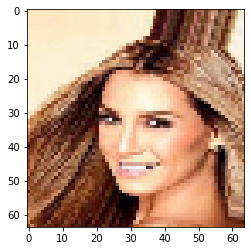

In [7]:
plt.imshow(img.numpy().astype("uint8"))

In [8]:
true_label = encoder(tf.expand_dims(img, axis=0), training=False)
recon_img = tf.Variable(tf.expand_dims(tf.random.normal(img.shape, 0, 1, tf.float32), axis=0), trainable=True)
print(img.shape, true_label.shape, recon_img.shape)

2023-04-16 14:35:59.972414: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201


(64, 64, 3) (1, 64, 64, 64) (1, 64, 64, 3)


In [9]:
temp_plain = np.reshape(true_label, newshape=(true_label.shape[0], true_label.shape[1]*true_label.shape[2]*true_label.shape[3]))
perturb_feat = fairRR(arr=temp_plain, eps=10.0, num_int=1, num_bit=10, mode = 'relax')
true_label = tf.convert_to_tensor(np.reshape(perturb_feat, newshape=true_label.shape))

1.0 0.0 (1, 262144) (1, 2621440)
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 1]
[0 0 0 0 0 0 0 0 0 1]
[0.         0.09496262]
[0.00390625 0.09765625]


In [10]:
loss_object = tf.keras.losses.MeanSquaredError()
def loss(model, label, img_, training):
    y_ = model(img_, training=training)
    return loss_object(y_true=label, y_pred=y_) + 0.001*tf.image.total_variation(images=tf.squeeze(img_, axis=0))

l = loss(encoder, true_label, img_=recon_img, training=False)
print("Loss test: {}".format(l))

Loss test: 11115.611328125


In [11]:
def grad(model, inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = loss(model, targets, inputs, training=False)
    return loss_value, tape.gradient(loss_value, inputs)

In [12]:
optimizer = tf.keras.optimizers.Adam(learning_rate=5)

In [13]:
loss_value, grads = grad(encoder, recon_img, true_label)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip([grads], [recon_img]))
print("Step: {},         Loss: {}".format(optimizer.iterations.numpy(),
                                          loss(encoder, true_label, recon_img, training=False).numpy()))

Step: 0, Initial Loss: 11115.611328125
Step: 1,         Loss: 10566.4345703125


In [14]:
train_loss_results = []

num_epochs = 500

for epoch in range(num_epochs):
    loss_value, grads = grad(encoder, recon_img, true_label)
    optimizer.apply_gradients(zip([grads], [recon_img]))
    if epoch % 10 == 0:
        print(f'epoch {epoch}, loss {loss_value}')

epoch 0, loss 10566.4345703125
epoch 10, loss 6515.7373046875
epoch 20, loss 4479.10498046875
epoch 30, loss 3193.981689453125
epoch 40, loss 2430.894775390625
epoch 50, loss 2032.6488037109375
epoch 60, loss 1852.158935546875
epoch 70, loss 1784.2569580078125
epoch 80, loss 1763.82421875
epoch 90, loss 1758.500244140625
epoch 100, loss 1757.13818359375
epoch 110, loss 1756.568603515625
epoch 120, loss 1756.0966796875
epoch 130, loss 1755.7220458984375
epoch 140, loss 1755.70947265625
epoch 150, loss 1755.693115234375
epoch 160, loss 1755.7791748046875
epoch 170, loss 1755.8291015625
epoch 180, loss 1755.6937255859375
epoch 190, loss 1755.86962890625
epoch 200, loss 1756.006103515625
epoch 210, loss 1755.9278564453125
epoch 220, loss 1756.057373046875
epoch 230, loss 1756.046142578125
epoch 240, loss 1756.03759765625
epoch 250, loss 1756.2108154296875
epoch 260, loss 1756.3609619140625
epoch 270, loss 1756.310546875
epoch 280, loss 1756.299072265625
epoch 290, loss 1756.365478515625
ep

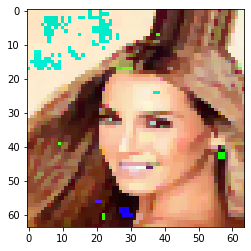

In [15]:
plt.imshow(np.squeeze(recon_img).astype("uint8"))
# plt.savefig('clean.jpg')